In [191]:
%matplotlib inline
import sys
sys.path.insert(0,'..')
from IPython.display import HTML,Image,SVG,YouTubeVideo
from helpers import header

HTML(header())

# Combined operations
## Morphological thinning and thickening 
by iterating the Hit-or-Miss transform and remove detected pixels from $X$.

* thinning

$$ X \oslash B = X \; | \;(X \otimes B)$$

* thickening

$$ X \odot B = X \cup (X \otimes B)$$

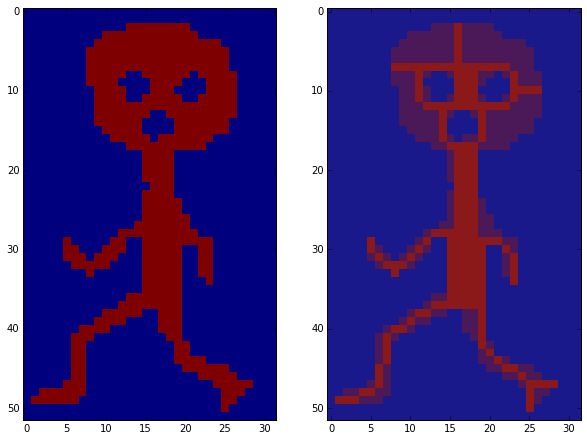

In [192]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.data import imread
from skimage.morphology import erosion

def hit_or_miss(X,B12):
    B1 = B12 == 1
    B2 = B12 == 0
    r = np.logical_and(erosion(X,B1),erosion(1-X,B2))
    return r

def rotate_4(B):
    #returns structuring element oriented in 4 directions
    return [B,np.rot90(B),np.rot90(np.rot90(B)),np.rot90(np.rot90(np.rot90(B)))]

X = (imread('http://homepages.ulb.ac.be/~odebeir/data/man.tif')>0)[:,:,0].astype(np.uint8)

B = np.array([[2,1,2],[0,1,1],[0,0,2]]) # . are coded with 2

#iterate on the four structuring element

selem = rotate_4(B)

R = X.copy()

for i in range(10):
    for s in selem:
        HoM = hit_or_miss(R,s)  
        R[HoM] = 0

plt.figure(figsize=[10,10])
plt.subplot(1,2,1)
plt.imshow(X,interpolation='nearest')
plt.subplot(1,2,2)
plt.imshow(X,interpolation='nearest',alpha = .8)
plt.imshow(R,interpolation='nearest',alpha=.5);



### skeleton extraction

A special case of thinning is the skeleton extraction, by applying the thickening for these two set of structuring elements, one can reduce every $X$ to single line structures sharing the same topology.

$$
\begin{matrix}
  0 & 0    & 0 \\
  \cdot     & 1    & \cdot \\
  1     & 1    & 1
 \end{matrix}
 $$
 
 and
 
 $$
\begin{matrix}
  \cdot & 0    & 0 \\
  1     & 1    & 0 \\
  \cdot     & 1    & \cdot
 \end{matrix}
 $$
 

and there 3 other orientations.

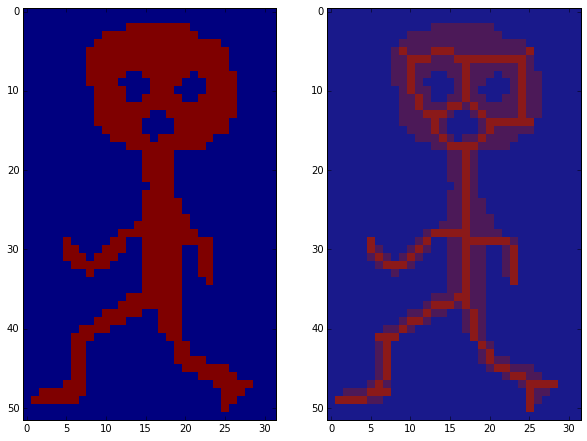

In [193]:
# skeletoninzing structuring elements
B1 = np.array([[0,0,0],[2,1,2],[1,1,1]])
B2 = np.array([[2,0,0],[1,1,0],[2,1,2]])
selem = rotate_4(B1) + rotate_4(B2) #join the two list of structuring element

R = X.copy()

for i in range(4):
    for s in selem:
        HoM = hit_or_miss(R,s)  
        R[HoM] = 0

plt.figure(figsize=[10,10])
plt.subplot(1,2,1)
plt.imshow(X,interpolation='nearest')
plt.subplot(1,2,2)
plt.imshow(X,interpolation='nearest',alpha = .8)
plt.imshow(R,interpolation='nearest',alpha=.5);


an application of the skeleton extraction is found in the pre-processing of fingerprints where we are looking for specific *minutiae*

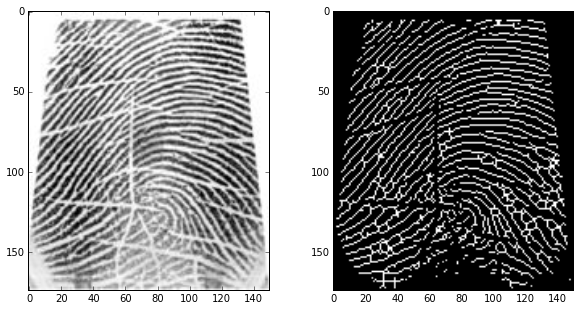

In [194]:
from skimage.filter import threshold_otsu

im = imread('http://biometrics.idealtest.org/userfiles/image/FingerprintV5Fig.1.jpg')[:,:150,0]
th_otsu = threshold_otsu(im)

R = (im<th_otsu).copy()

for i in range(4):
    for s in selem:
        HoM = hit_or_miss(R,s)  
        R[HoM] = 0

plt.figure(figsize=[10,5])
plt.subplot(1,2,1)
plt.imshow(im,cmap=plt.cm.gray);

plt.subplot(1,2,2)
plt.imshow(R,cmap=plt.cm.gray);

>see also:
* Morphological algorithms [DIPM](../00-Preface/06-References.ipynb#[DIPM]) pp143-166

### Pruning

The skeleton, or other morphological processing can produce unwanted small artifacts, these irragularities can often be removed used by a process called pruning. 

Pruning is a specific thinning algorithm using the following structuring element (and ther rotations):

$$
\begin{matrix}
  0 & 0    & 0 \\
  0     & 1    & 0 \\
  0     & \cdot    & \cdot
 \end{matrix}
 $$
 
 and
 
 $$
\begin{matrix}
  0 & 0    & 0 \\
  0     & 1    & 0 \\
  \cdot     & \cdot    & 0
 \end{matrix}
 $$
 
 and there 3 other orientations,
 example of a pruning applied iteratively on a binary skeleton:

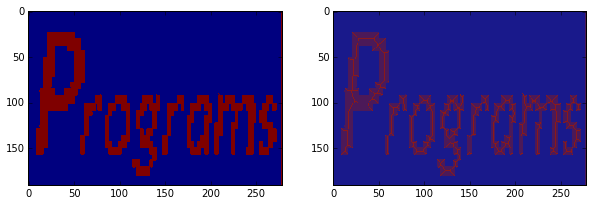

In [195]:
ima = imread('http://homepages.ulb.ac.be/~odebeir/data/programs.png')[:,:,0] >10

# skeletoninzing structuring elements
B1 = np.array([[0,0,0],[2,1,2],[1,1,1]])
B2 = np.array([[2,0,0],[1,1,0],[2,1,2]])
selem = rotate_4(B1) + rotate_4(B2) #join the two list of structuring element

R = ima.copy()

for i in range(12):
    for s in selem:
        HoM = hit_or_miss(R,s)  
        R[HoM] = 0

plt.figure(figsize=[10,10])
plt.subplot(1,2,1)
plt.imshow(ima,interpolation='nearest')
plt.subplot(1,2,2)
plt.imshow(ima,interpolation='nearest',alpha = .8)
plt.imshow(R,interpolation='nearest',alpha=.5);


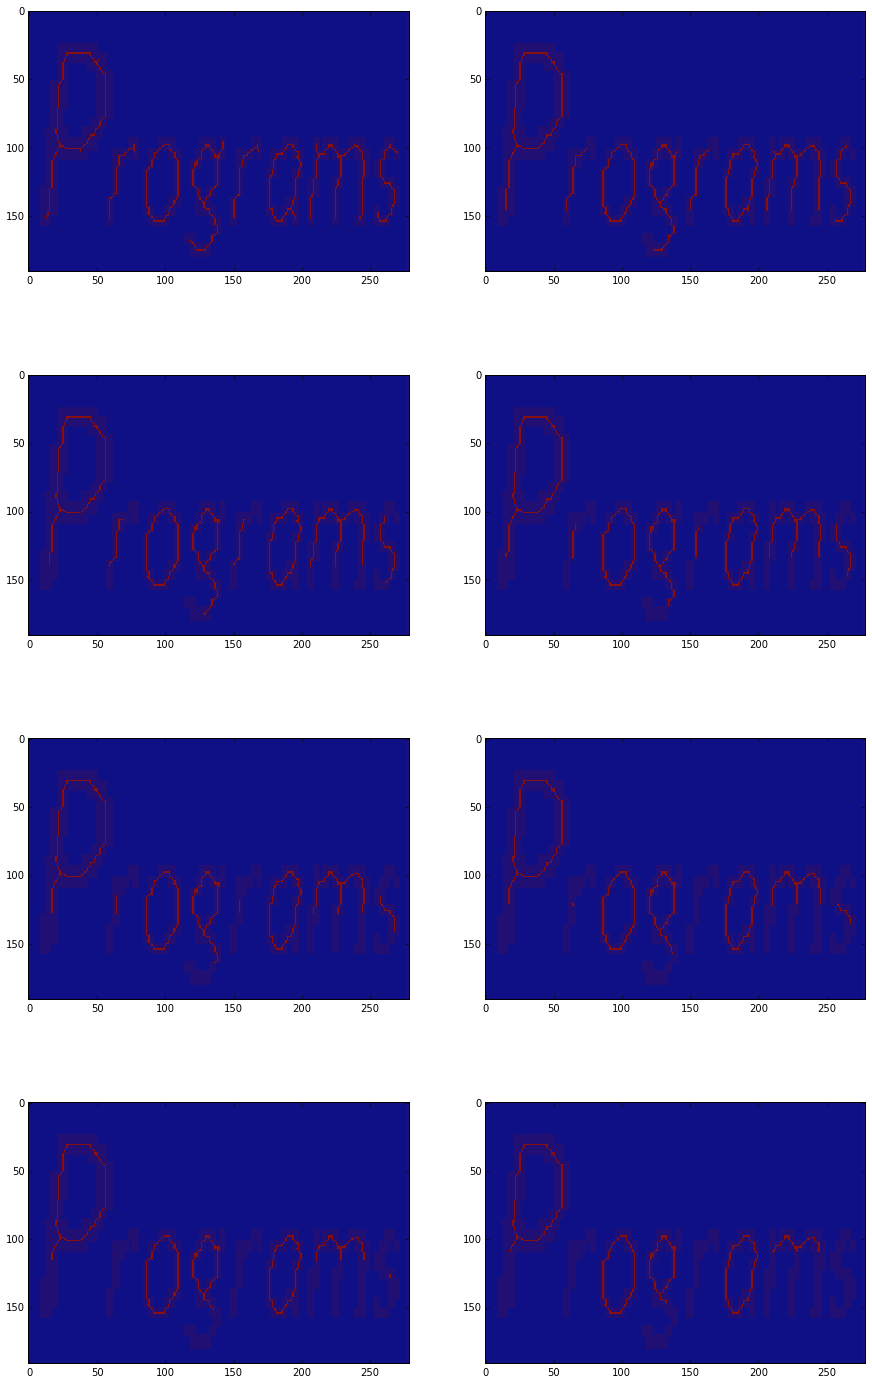

In [196]:
# pruning structuring elements
B1 = np.array([[0,0,0],[0,1,0],[0,2,2]])
B2 = np.array([[0,0,0],[0,1,0],[2,2,0]])
selem = rotate_4(B1) + rotate_4(B2) #join the two list of structuring element

plt.figure(figsize=[15,25])

k = 1
for i in range(24):
    for s in selem:
        HoM = hit_or_miss(R,s)  
        R[HoM] = 0

    if k%3 == 0:
        plt.subplot(4,2,k/3)
        plt.imshow(ima,interpolation='nearest',alpha = .7)
        plt.imshow(R.copy(),interpolation='nearest',alpha=.8);
    k += 1



## Distance Map 

The distance function $dist_X$ associate to a set $X$, the distance for each point of $X$ to the background

$$ dist_X(p) = min\{n \in \mathbb \; | \; p \notin X \ominus nB \}$$

explicit distance map (brute force) computing can be computer intensive, therefore other appriximated distance are proposed

* the city-block distance

$$
\begin{matrix}
 & 1    &  \\
1     & 0    & 1 \\
 & 1    &  \\
 \end{matrix}
 $$

* the chess-board distance

$$
\begin{matrix}
1 & 1  & 1 \\
1     & 0    & 1 \\
1 & 1  & 1 \\
 \end{matrix}
 $$

* the chamfer distance

$$
\begin{matrix}
4 & 3  & 4 \\
3     & 0    & 3 \\
4 & 3  & 4 \\
 \end{matrix}
 $$


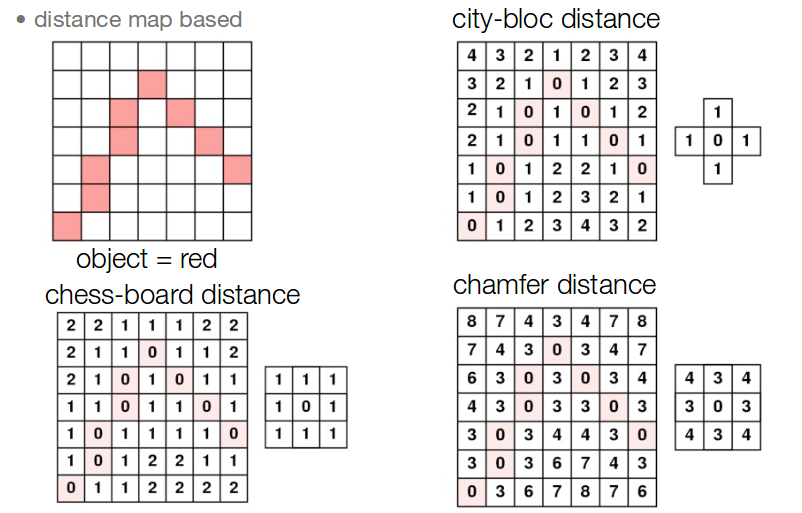

In [197]:
Image('http://homepages.ulb.ac.be/~odebeir/data/distances.png')

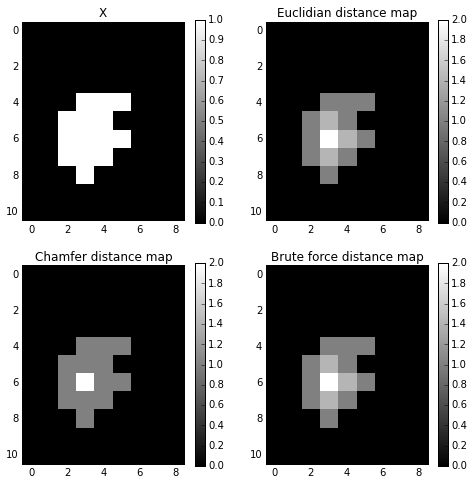

In [198]:
from numpy import genfromtxt
from scipy.ndimage import distance_transform_cdt,distance_transform_edt,distance_transform_bf

X = genfromtxt('../data/morpho_x.csv', delimiter=',',filling_values=0)
dist_X = distance_transform_edt(X)
dist_bf = distance_transform_bf(X)
dist_c = distance_transform_cdt(X)

plt.figure(figsize=[8,8])
plt.subplot(2,2,1)
plt.imshow(X,interpolation='nearest',cmap=plt.cm.gray);X = np.zeros((10,10))
plt.title('X')
plt.colorbar()
plt.subplot(2,2,2)
plt.imshow(dist_X,interpolation='nearest',cmap=plt.cm.gray);X = np.zeros((10,10))
plt.title('Euclidian distance map')
plt.colorbar();
plt.subplot(2,2,3)
plt.imshow(dist_c,interpolation='nearest',cmap=plt.cm.gray);X = np.zeros((10,10))
plt.title('Chamfer distance map')
plt.colorbar()
plt.subplot(2,2,4)
plt.imshow(dist_bf,interpolation='nearest',cmap=plt.cm.gray);X = np.zeros((10,10))
plt.title('Brute force distance map')
plt.colorbar();


>see also:
* Distance Function [DIP](../00-Preface/06-References.ipynb#[DIP]) p.73
* Euclidian Distance Map [IPH](../00-Preface/06-References.ipynb#[IPH])

## Ultimate Eroded Point (UEP) 

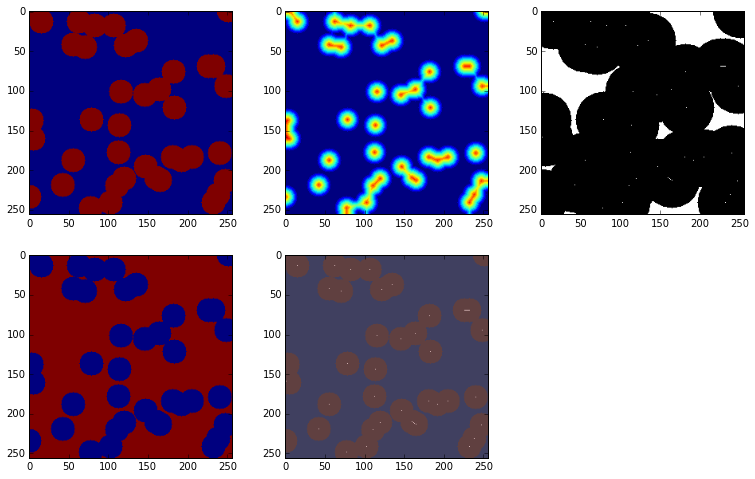

In [199]:
import numpy as np
from skimage.morphology import disk
import skimage.filter.rank as skr
from scipy import ndimage as ndi

np.random.seed(1)
n = np.random.random((256,256))<.0005
d = skr.maximum(n,disk(15))

distance = ndi.distance_transform_edt(d).astype(np.uint8)
local_max = distance == skr.maximum(distance,disk(20))
background = distance == 0
c_local_max = local_max.copy()
c_local_max[background] = 0


plt.figure(figsize=[13,8])
plt.subplot(2,3,1)
plt.imshow(d)
plt.subplot(2,3,2)
plt.imshow(distance)
plt.subplot(2,3,3)
plt.imshow(local_max,cmap=plt.cm.gray)
plt.subplot(2,3,4)
plt.imshow(background)
plt.subplot(2,3,5)
plt.imshow(d,alpha=.5)
plt.imshow(c_local_max,cmap=plt.cm.gray,alpha=.5);

>see also:
* Ultimate Eroded Point [IPH](../00-Preface/06-References.ipynb#[IPH])

## Object labeling

The object labeling consist in assigning a unique integer value to each connected component of a binary image.

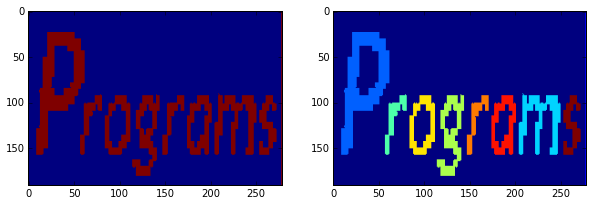

In [200]:
from skimage.measure import label

ima = imread('http://homepages.ulb.ac.be/~odebeir/data/programs.png')[:,:,0] >10

lab = label(ima,background=0)
plt.figure(figsize=[10,20])
plt.subplot(1,2,1)
plt.imshow(ima)
plt.subplot(1,2,2)
plt.imshow(lab);

## Hole filling

## Alternate Sequential Filter

## Morphological texture analysis 

>see also:
* Morphological texture analysis [DIPM](../00-Preface/06-References.ipynb#[DIPM]) pp43-102